In [1]:
import coremltools as ct

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import IPython
import IPython.display

In [3]:
from preprocess.data_generator import WindowSplitter
from nn.deepar import create_model
from preprocess.data_generator import DatasetGenerator

In [4]:
CSV_FILE = "../data/data.csv"
df = pd.read_csv(CSV_FILE)
df = df.drop(columns=['t'])
df = df.replace(-255.0, np.nan)
df = df.interpolate('linear')
display(df[:3])
len(df)

,x,y,z,tx1,tx2,tx3,tx4,tx5,tx6,tx7,...,tx16,tx17,tx18,tx19,tx20,tx21,tx22,tx23,tx24,tx25
0,750.02,598.52,94.50,-55.0,-62.0,-67.0,-63.0,-66.0,-69.0,-67.0,...,-74.0,-72.0,-70.0,-69.0,-68.0,-67.0,-57.0,-53.0,-73.0,-61.0
1,759.46,579.46,94.11,-55.0,-63.0,-67.0,-63.0,-66.0,-68.0,-67.0,...,-77.0,-72.0,-66.0,-71.0,-57.0,-68.0,-62.0,-56.0,-74.0,-62.0
2,770.00,559.05,94.94,-56.0,-62.0,-60.0,-62.0,-58.0,-48.0,-66.0,...,-74.0,-71.0,-47.0,-70.0,-60.0,-65.0,-61.0,-51.0,-73.0,-62.0


16936

In [5]:
CHECKPOINT_PATH = "../checkpoints/deepar"

def restore_model(columns):
    model = create_model(dim_x=len(columns[3:]), dim_z=3)
    # restore checkpoints if exist
    ckpt = tf.train.Checkpoint(model=model)
    ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=100)
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("Restoring checkpoint from {}".format(ckpt_manager.latest_checkpoint))
    return model
model = restore_model(columns=list(df.columns))

Restoring checkpoint from ../checkpoints/deepar\ckpt-100


In [6]:
from preprocess.data_generator import WindowSplitter

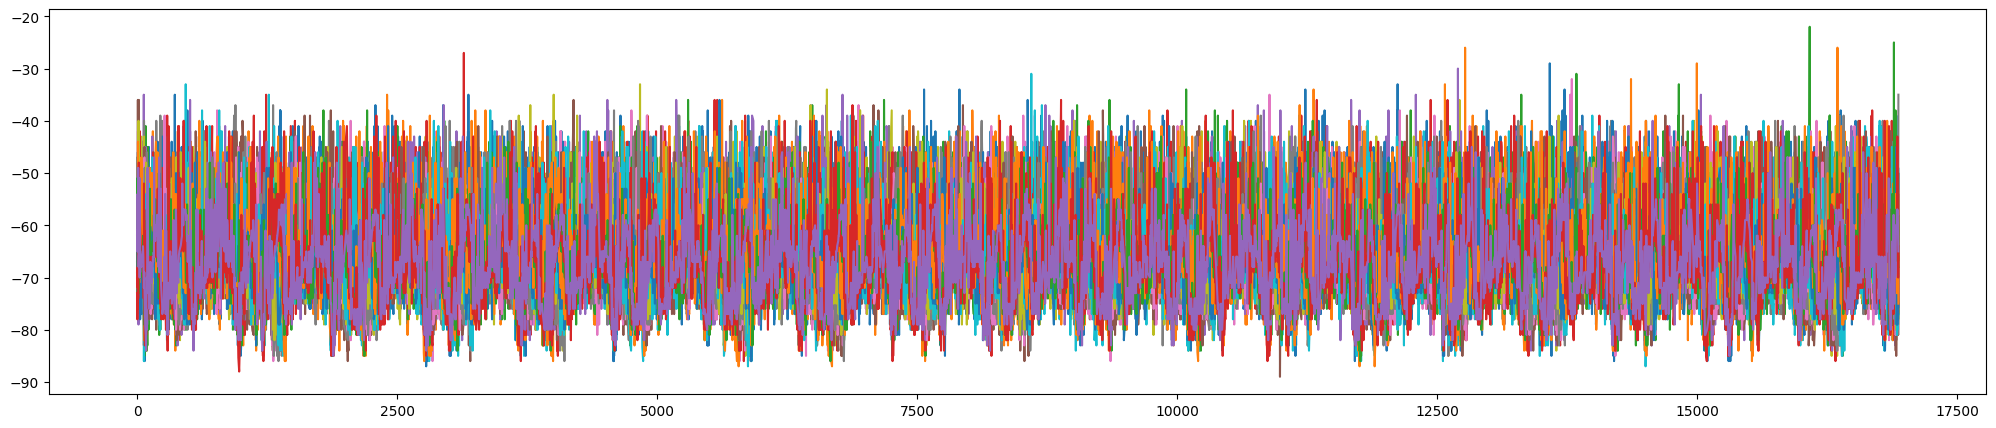

In [7]:
def prep_data(df):
    raw_df = df.copy()
    # keep all 'tx'
    input_df = raw_df[list(df.columns)[3:]].astype('float')
    # only keep 'x','y'
    label_df = raw_df[['x','y','z']]

    plt.figure(figsize=(25,5))
    plt.plot(input_df)
    plt.show()
    
    # concat label with input as new df
    new_df = pd.concat([label_df, input_df], axis=1)
    # get the diff of each rows
    # diff_df = new_df.diff(axis=0)[1:]
    # normalize
    norm_df = (new_df-new_df.mean())/(new_df.std() + 1e-10)
    norm_df = norm_df.interpolate('linear')
    norm_df = norm_df.dropna().reset_index(drop=True)

    return norm_df, new_df
norm_df, new_df = prep_data(df)

In [8]:
gen = DatasetGenerator(data=norm_df,
                       input_width=50,
                       label_width=50,
                       shift=0,
                       columns=list(norm_df),
                       input_columns=norm_df.columns[3:],
                       label_columns=norm_df.columns[:3],
                       batch_size=1,
                       partition=(1, 0, 0))

In [9]:
def model_plot2D(model, data, batch_index, title='',warmup_step=10, df_mean=0, df_std=1, x_offset=0, y_offset=0):
    plt.figure(figsize=(20,10))
    inputs, labels = data
    means, _ = model(inputs[:,:,:])
    mean = (means[batch_index, :] * df_std + df_mean) * 0.01 # convert unreal unit to meter
    label = (labels[batch_index, :] * df_std + df_mean) * 0.01 # convert unreal unit to meter
    
    # as a velocity value we need to performance .cumsum(), to convert it back to the change of position
    # plt.plot(mean[warmup_step:, 0].numpy() + x_offset, mean[warmup_step:, 1].numpy() + y_offset, '-r', alpha=0.5)
    
    plt.scatter(mean[warmup_step:, 0].numpy() + x_offset, mean[warmup_step:, 1].numpy() + y_offset, s=30, marker='x', alpha=1)
    plt.scatter(label[warmup_step:,0].numpy() + x_offset, label[warmup_step:,1].numpy() + y_offset, s=30, marker='.', alpha=1)
    plt.legend(labels=['Prediction', 'Ground Truth'], loc='lower left')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title(title)
    plt.axis('equal')
    plt.show()

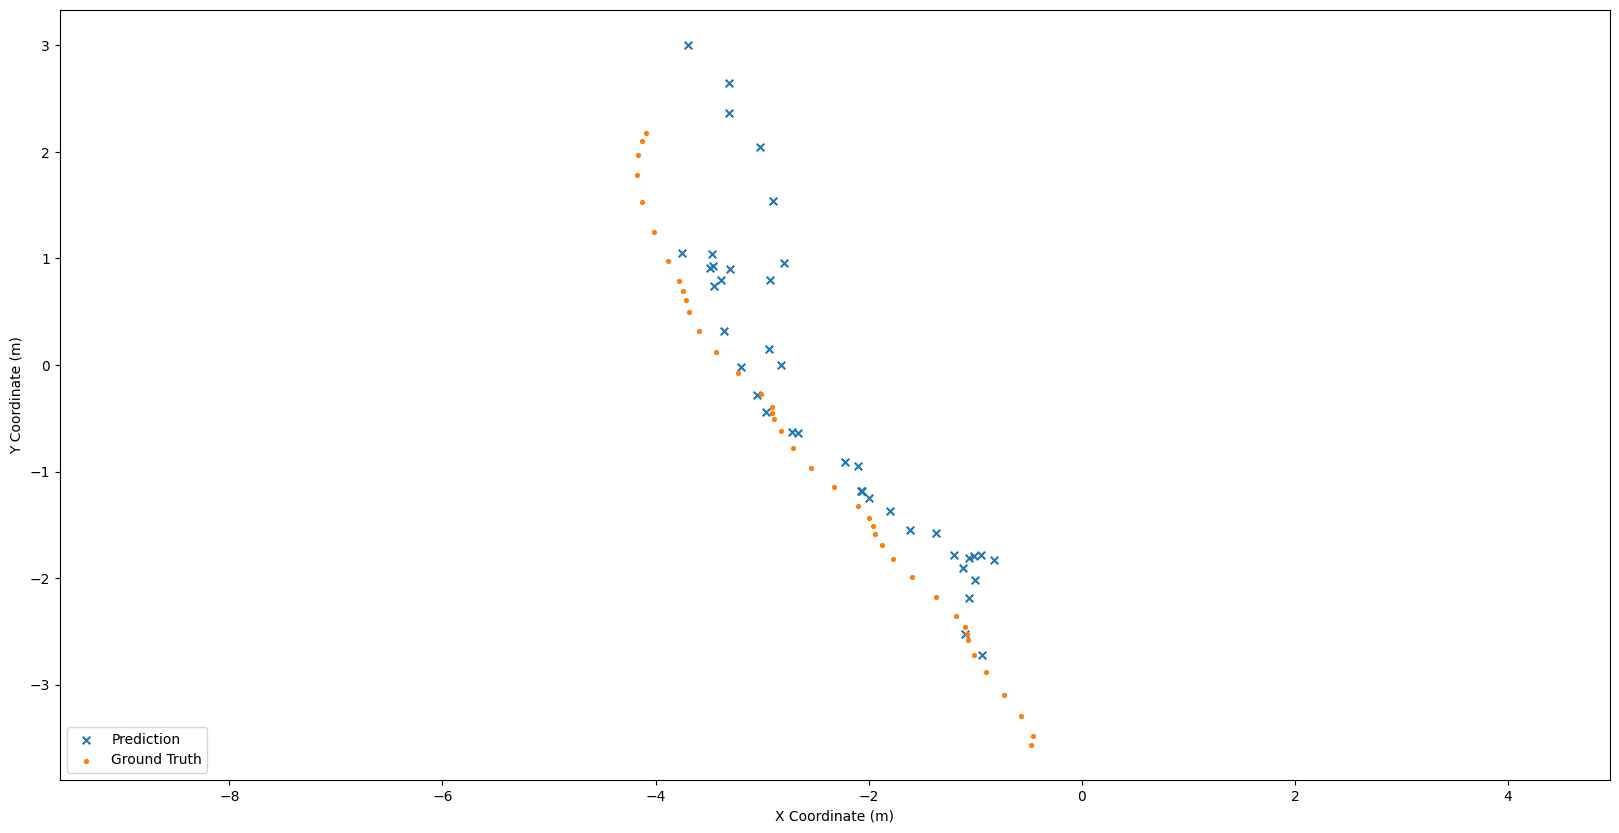

In [10]:
example = next(iter(gen.train_ds))
model_plot2D(model, example, 0, df_mean=new_df.mean()[:3], df_std=new_df.std()[:3] + 1e-10) # [:3] is label columns x,y,z

In [11]:
mlmodel = ct.convert(model, package_dir="~/deepar.mlpackage")

Running TensorFlow Graph Passes:  33%|███████████████▎                              | 2/6 [00:00<00:01,  2.07 passes/s]


NotImplementedError: Branch not found.